In [1]:
!pip install numpy pandas opencv-python matplotlib torch torchvision transformers scikit-learn


In [2]:
import numpy as np
import pandas as pd
import cv2
import torch
import torchvision
from transformers import pipeline

print("Libraries installed and working successfully!")


Libraries installed and working successfully!


In [ ]:
from google.colab import files
files.upload()

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d msambare/fer2013


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 71% 43.0M/60.3M [00:00<00:00, 225MB/s]
100% 60.3M/60.3M [00:00<00:00, 221MB/s]


In [6]:
!unzip fer2013.zip -d fer2013


Streaming output truncated to the last 5000 lines.
  inflating: fer2013/train/sad/Training_65242339.jpg  
  inflating: fer2013/train/sad/Training_65267116.jpg  
  inflating: fer2013/train/sad/Training_65275626.jpg  
  inflating: fer2013/train/sad/Training_6529266.jpg  
  inflating: fer2013/train/sad/Training_65329617.jpg  
  inflating: fer2013/train/sad/Training_65338712.jpg  
  inflating: fer2013/train/sad/Training_65338797.jpg  
  inflating: fer2013/train/sad/Training_65387162.jpg  
  inflating: fer2013/train/sad/Training_65404494.jpg  
  inflating: fer2013/train/sad/Training_65426218.jpg  
  inflating: fer2013/train/sad/Training_65430136.jpg  
  inflating: fer2013/train/sad/Training_65437377.jpg  
  inflating: fer2013/train/sad/Training_6545735.jpg  
  inflating: fer2013/train/sad/Training_65463385.jpg  
  inflating: fer2013/train/sad/Training_65473985.jpg  
  inflating: fer2013/train/sad/Training_65502829.jpg  
  inflating: fer2013/train/sad/Training_65505359.jpg  
  inflating: fer

Class to Emotion Mapping: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


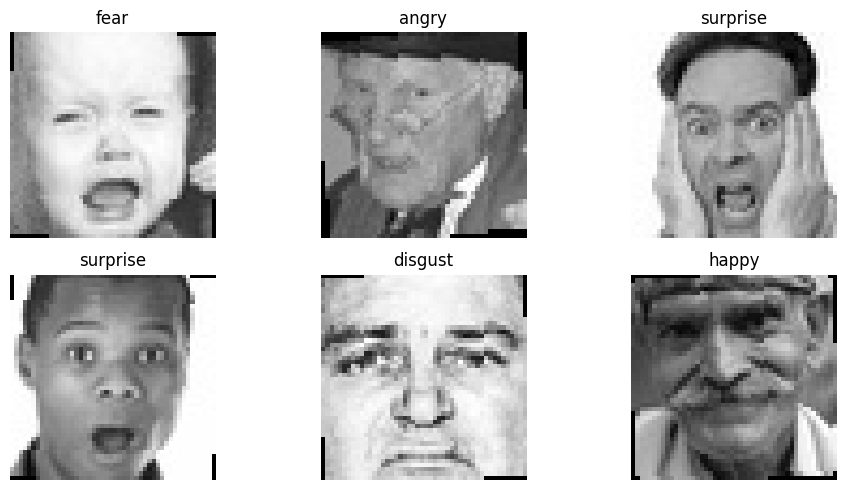

Training set size: 28709
Test set size: 7178


In [13]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally
    transforms.RandomRotation(10),  # Rotate images by +/- 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Path to the dataset
train_path = "fer2013/train"
test_path = "fer2013/test"

# Load the train and test datasets
train_data = datasets.ImageFolder(root=train_path, transform=transform)
test_data = datasets.ImageFolder(root=test_path, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Map class indices to emotions
emotions_map = {idx: emotion for emotion, idx in train_data.class_to_idx.items()}
print("Class to Emotion Mapping:", emotions_map)

# Visualize some sample images
def visualize_data(data_loader, emotions_map):
    images, labels = next(iter(data_loader))
    plt.figure(figsize=(10, 5))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].squeeze(0), cmap="gray")
        plt.title(emotions_map[labels[i].item()])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_data(train_loader, emotions_map)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

In [14]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final fully connected layer for FER2013
num_classes = 7  # FER2013 has 7 emotion classes
# Replace the final layer with a fully connected + dropout
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout with 50% probability
    nn.Linear(512, num_classes)
)

# Move the model to the GPU/CPU
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



Using device: cuda


In [15]:
from torch.optim.lr_scheduler import StepLR

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)  # Halve LR every 2 epochs


In [16]:
def train_model_with_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f"Training Loss: {train_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Step the scheduler
        scheduler.step()


In [17]:
train_model_with_scheduler(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=10)


Epoch 1/10


100%|██████████| 449/449 [00:31<00:00, 14.16it/s]


Training Loss: 1.6080, Training Accuracy: 37.02%
Validation Loss: 1.4515, Validation Accuracy: 42.66%
Epoch 2/10


100%|██████████| 449/449 [00:29<00:00, 15.17it/s]


Training Loss: 1.4216, Training Accuracy: 45.54%
Validation Loss: 1.3235, Validation Accuracy: 47.70%
Epoch 3/10


100%|██████████| 449/449 [00:30<00:00, 14.93it/s]


Training Loss: 1.2868, Training Accuracy: 51.01%
Validation Loss: 1.2688, Validation Accuracy: 51.31%
Epoch 4/10


100%|██████████| 449/449 [00:30<00:00, 14.84it/s]


Training Loss: 1.2294, Training Accuracy: 54.32%
Validation Loss: 1.2100, Validation Accuracy: 53.90%
Epoch 5/10


100%|██████████| 449/449 [00:30<00:00, 14.64it/s]


Training Loss: 1.1409, Training Accuracy: 57.27%
Validation Loss: 1.1547, Validation Accuracy: 56.17%
Epoch 6/10


100%|██████████| 449/449 [00:30<00:00, 14.95it/s]


Training Loss: 1.0980, Training Accuracy: 59.40%
Validation Loss: 1.1378, Validation Accuracy: 57.08%
Epoch 7/10


100%|██████████| 449/449 [00:30<00:00, 14.89it/s]


Training Loss: 1.0277, Training Accuracy: 62.15%
Validation Loss: 1.1085, Validation Accuracy: 58.02%
Epoch 8/10


100%|██████████| 449/449 [00:30<00:00, 14.72it/s]


Training Loss: 0.9903, Training Accuracy: 63.51%
Validation Loss: 1.1020, Validation Accuracy: 59.06%
Epoch 9/10


100%|██████████| 449/449 [00:30<00:00, 14.64it/s]


Training Loss: 0.9435, Training Accuracy: 65.31%
Validation Loss: 1.1010, Validation Accuracy: 59.04%
Epoch 10/10


100%|██████████| 449/449 [00:30<00:00, 14.72it/s]


Training Loss: 0.9183, Training Accuracy: 66.05%
Validation Loss: 1.0993, Validation Accuracy: 58.93%


Test Loss: 1.0949
Test Accuracy: 59.14%


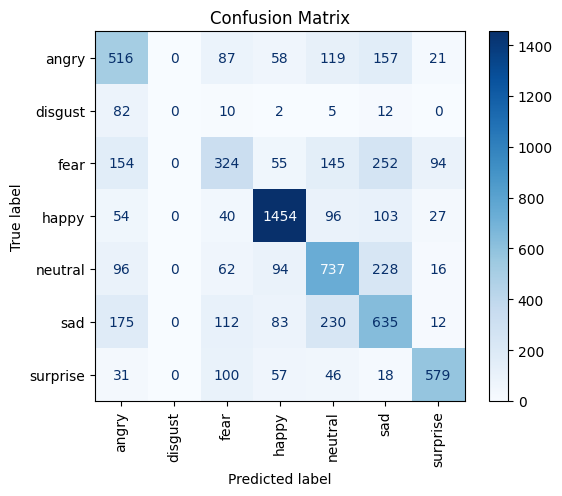

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Evaluate the model on the test set
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(emotions_map.values()))
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()

# Call the evaluation function
evaluate_model(model, test_loader, criterion)


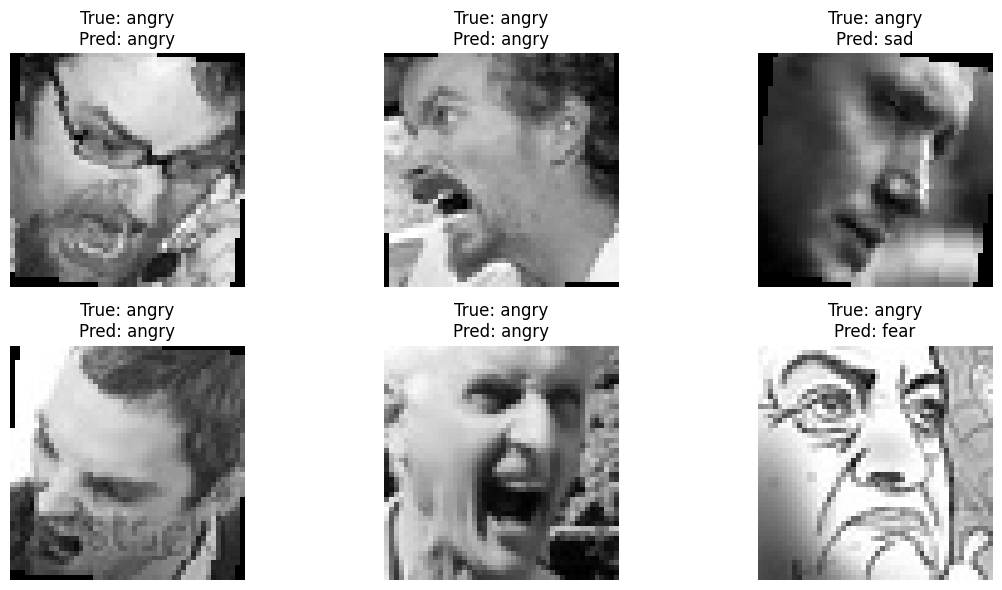

In [19]:
def visualize_predictions(model, test_loader, emotions_map):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].cpu().squeeze(0), cmap="gray")
        plt.title(f"True: {emotions_map[labels[i].item()]}\nPred: {emotions_map[preds[i].item()]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_predictions(model, test_loader, emotions_map)


In [20]:
!pip install transformers


In [24]:
from transformers import pipeline

# Load a sentiment analysis model that includes neutral sentiment
sentiment_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", device=0)

# Test Sentiment Analysis
texts = [
    "I am so happy today!",  # Positive sentiment
    "This is the worst day of my life.",  # Negative sentiment
    "I feel neutral about this."  # Neutral sentiment
]

# Analyze sentiments
sentiments = sentiment_analyzer(texts)
# Mapping labels to sentiments
sentiment_map = {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}

# Display the results with mapped labels
for text, sentiment in zip(texts, sentiments):
    sentiment_label = sentiment_map[sentiment['label']]
    print(f"Text: {text}")
    print(f"Sentiment: {sentiment_label}, Confidence: {sentiment['score']:.2f}")



Text: I am so happy today!
Sentiment: Positive, Confidence: 0.99
Text: This is the worst day of my life.
Sentiment: Negative, Confidence: 0.98
Text: I feel neutral about this.
Sentiment: Neutral, Confidence: 0.55


In [27]:
def multimodal_predict(image, text, vision_model, sentiment_analyzer, emotions_map, sentiment_map):
    # Vision prediction
    vision_model.eval()
    with torch.no_grad():
        image = image.to(device)
        image = image.unsqueeze(0)  # Add batch dimension (1, 1, 48, 48)
        output = vision_model(image)  # Pass image through the model
        _, vision_pred = torch.max(output, 1)
        vision_emotion = emotions_map[vision_pred.item()]

    # Text sentiment prediction
    sentiment = sentiment_analyzer(text)[0]
    sentiment_label = sentiment_map[sentiment['label']]
    sentiment_confidence = sentiment['score']

    # Combine predictions
    combined_result = {
        "Vision Prediction": vision_emotion,
        "Text Sentiment": sentiment_label,
        "Sentiment Confidence": sentiment_confidence
    }

    return combined_result


In [28]:
# Example test input
image, label = next(iter(test_loader))
sample_image = image[0]  # Select the first image in the batch
sample_text = "I am very happy with this result!"

# Define mappings
emotions_map = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}
sentiment_map = {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}

# Get multimodal predictions
result = multimodal_predict(sample_image, sample_text, model, sentiment_analyzer, emotions_map, sentiment_map)

# Display the combined result
print("Multimodal Prediction:")
print(result)


Multimodal Prediction:
{'Vision Prediction': 'happy', 'Text Sentiment': 'Positive', 'Sentiment Confidence': 0.9917888045310974}


In [29]:
def evaluate_multimodal(test_loader, vision_model, sentiment_analyzer, emotions_map, sentiment_map):
    vision_model.eval()  # Set vision model to evaluation mode
    images, labels = next(iter(test_loader))  # Get a batch of images and labels
    text_inputs = [
        "I am so happy!",  # Positive
        "This is terrible!",  # Negative
        "I feel neutral about this."  # Neutral
    ]

    # Repeat text inputs to match the batch size
    text_inputs = text_inputs * (len(images) // len(text_inputs)) + text_inputs[:len(images) % len(text_inputs)]

    # Process predictions
    predictions = []
    for i in range(len(images)):
        image = images[i]
        text = text_inputs[i]
        prediction = multimodal_predict(image, text, vision_model, sentiment_analyzer, emotions_map, sentiment_map)
        predictions.append(prediction)

    # Visualize predictions
    plt.figure(figsize=(12, 8))
    for i in range(6):  # Visualize first 6 examples
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].squeeze(0), cmap="gray")
        plt.title(f"Vision: {predictions[i]['Vision Prediction']}\n"
                  f"Text: {text_inputs[i]}\n"
                  f"Sentiment: {predictions[i]['Text Sentiment']} ({predictions[i]['Sentiment Confidence']:.2f})")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


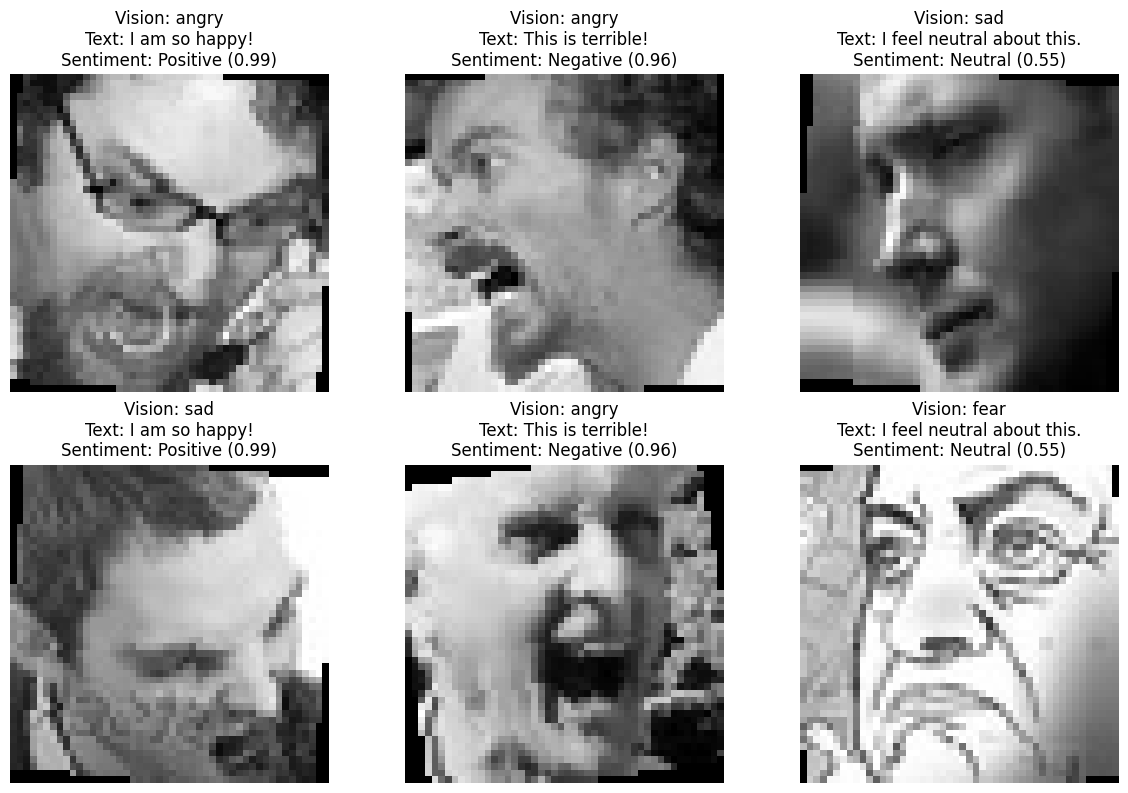

In [30]:
# Call the evaluation function
evaluate_multimodal(test_loader, model, sentiment_analyzer, emotions_map, sentiment_map)